<h2 align='center'>Phase Change Material</h2>

Import the required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import integrate
import seaborn as sns

In [54]:
# Load the dataset
df=pd.read_excel('../data/pcmdata.xlsx')

In [3]:
# Look at the data
print(df.shape)
df.head()

(15, 11)


,pcm,molar_mass,T_fus,Del_H,cpsa,cpsb,cpsc,cpla,cplb,cplc,cpld
0,Heptanoic (enanthic) acid,130.18,-7.4,107,164.213,-1.1939,0.006150,72.739,1.36180,-0.003304,0.000003
1,Nonanoic (pelargonic) acid,156.24,12.3,127,9.000,1.4120,0.000000,184.223,1.21100,-0.002921,0.000003
2,Oleic (elainic) acid,282.47,13.5,140,-77.434,1.6642,0.000000,278.686,2.54340,-0.005436,0.000005
3,Octanoic (caprylic) acid,144.21,16.5,148,241.472,-1.6054,0.006494,184.525,0.99722,-0.002423,0.000003
4,Undecanoic (undecylic) acid,186.29,28.4,139,11.000,1.4556,0.000000,73.094,2.33810,-0.005291,0.000005


In [4]:
class PcmProperties():
    """
       This class allows us to calculate the properties of etutectic organic phase change materials
       Ex: new_pcm = PcmProperties(pcm_data)
           new_pcm.
    """
    def __init__(self, data):
        self.name = data[0]
        self.molar_mass = data[1]
        self.fusion_T = data[2]+273.15
        self.heat_of_fusion = data[3]*data[1]
        self.cp_solid_a = data[4]
        self.cp_solid_b = data[5]
        self.cp_solid_c = data[6]
        self.cp_liquid_a = data[7]
        self.cp_liquid_b = data[8]
        self.cp_liquid_c = data[9]
        self.cp_liquid_d = data[10]
    

In [5]:
A = PcmProperties(df[df['pcm']==df['pcm'][0]].values.tolist()[0])
B = PcmProperties(df[df['pcm']==df['pcm'][1]].values.tolist()[0])

In [23]:
class EutecticMixture():
      #Ideal gas constant in J/mol.K
    def __init__(self,A,B):
        self.A = A
        self.B = B
        self.R = 8.314
    def eutectic_properties(self):
        self.mole_fraction_A = [i for i in np.arange(0.0005,0.9995,0.0001)]
        self.temperature_BA = list(map(lambda xA: (self.A.fusion_T*self.A.heat_of_fusion)/(self.A.heat_of_fusion-self.R*self.A.fusion_T*math.log(xA)),self.mole_fraction_A))
        self.temperature_AB = list(map(lambda xA: (self.B.fusion_T*self.B.heat_of_fusion)/(self.B.heat_of_fusion-self.R*self.B.fusion_T*math.log(1-xA)),self.mole_fraction_A))
        for j in range(len(self.temperature_BA)-1):
            err0 = self.temperature_AB[j]-self.temperature_BA[j] 
            err1 = self.temperature_AB[j+1]-self.temperature_BA[j+1]
            if err0*err1<0:
                break
        self.TE = (self.temperature_AB[j]+self.temperature_BA[j])/2
        self.xE = j*0.0001
        return self.TE, self.xE
    def plot_temp_AB(self):
        sns.set_theme()
        plt.scatter(self.mole_fraction_A,self.temperature_AB,marker =".")
        plt.scatter(self.mole_fraction_A,self.temperature_BA,marker =".")
        # To plot lines
        font1 = {'family':'serif','color':'blue','size':18}
        font2 = {'family':'serif','color':'darkred','size':12}

        min_value = min(self.temperature_AB+self.temperature_BA)
        plt.plot([0,self.xE,self.xE],[self.TE,self.TE,min_value])
        plt.title("Plots of liquidus lines",fontdict = font1)
        #plt.text(-0.1,B.fusion_T-273.15,"$TB$")
        plt.annotate(f'(xE={self.xE}, TE={round(self.TE,2)})', xy=(self.xE, self.TE),xytext=(self.xE+0.2,self.TE-20),arrowprops=dict(facecolor='red', shrink=0.05))
        plt.xlabel("Mole fraction of A",fontdict = font2)
        plt.ylabel("Temperature ($T^oC$)",fontdict = font2)
        plt.show()
    def entropy(self):
        ds1_integrand = lambda T: (self.B.cp_solid_a + self.B.cp_solid_b*T +self.B.cp_solid_c*T**2)/T
        self.ds1 = (1-self.xE)*integrate.quad(ds1_integrand,self.TE,self.B.fusion_T)[0]
        self.ds2 = (1-self.xE)*self.B.heat_of_fusion/self.B.fusion_T
        
        ds3_integrand = lambda T: (self.A.cp_solid_a + self.A.cp_solid_b*T + self.A.cp_solid_c*T**2)/T
        self.ds3 = self.xE*integrate.quad(ds3_integrand,self.TE,self.A.fusion_T)[0]
        self.ds4 = self.xE*self.A.heat_of_fusion/self.A.fusion_T
        ds5_integrand = lambda T: (self.A.cp_liquid_a+self.A.cp_liquid_b*T+self.A.cp_liquid_c*T**2+self.A.cp_liquid_d*T**3)/T
        self.ds5 = self.xE*integrate.quad(ds5_integrand,self.A.fusion_T,self.B.fusion_T)[0]
        self.ds6 = -self.R*(self.xE*math.log(self.xE) + (1-self.xE)*math.log(1-self.xE))
        ds7_integrand = lambda T: (self.xE*(self.A.cp_liquid_a+self.A.cp_liquid_b*T +self.A.cp_liquid_c*T**2+ self.A.cp_liquid_d*T**3)+ (1-self.xE)*(self.B.cp_liquid_a+self.B.cp_liquid_b*T +self.B.cp_liquid_c*T**2+ self.B.cp_liquid_d*T**3))/T
        self.ds7 = integrate.quad(ds7_integrand,self.B.fusion_T,self.TE)[0]
        self.ds_total = self.ds1 + self.ds2 + self.ds3 + self.ds4 + self.ds5 + self.ds6 + self.ds7 
        return self.ds_total
    
    def enthalpy(self):
        dh1_integrand = lambda T: (self.B.cp_solid_a + self.B.cp_solid_b*T +self.B.cp_solid_c*T**2)
        self.dh1 = (1-self.xE)*integrate.quad(dh1_integrand,self.TE,self.B.fusion_T)[0]
        self.dh2 = (1-self.xE)*self.B.heat_of_fusion
        dh3_integrand = lambda T: (self.A.cp_solid_a + self.A.cp_solid_b*T + self.A.cp_solid_c*T**2)
        self.dh3 = self.xE*integrate.quad(dh3_integrand,self.TE,self.A.fusion_T)[0]
        self.dh4 = self.xE*self.A.heat_of_fusion
        dh5_integrand = lambda T: (self.A.cp_liquid_a+self.A.cp_liquid_b*T+self.A.cp_liquid_c*T**2+self.A.cp_liquid_d*T**3)
        self.dh5 = self.xE*integrate.quad(dh5_integrand,self.A.fusion_T,self.B.fusion_T)[0]
        self.dh6 = 0
        dh7_integrand = lambda T: (self.xE*(self.A.cp_liquid_a+self.A.cp_liquid_b*T +self.A.cp_liquid_c*T**2+ self.A.cp_liquid_d*T**3)+ (1-self.xE)*(self.B.cp_liquid_a+self.B.cp_liquid_b*T +self.B.cp_liquid_c*T**2+ self.B.cp_liquid_d*T**3))
        self.dh7 = integrate.quad(dh7_integrand,self.B.fusion_T,self.TE)[0]
        self.dh_total = self.dh1 + self.dh2 + self.dh3 + self.dh4 + self.dh5 + self.dh6 + self.dh7
        return self.dh_total
        

        
    def plot_entropy(self):
        self.entropy()
        
        x_entropy = ['$\Delta S1$','$\Delta S2$','$\Delta S3$','$\Delta S4$','$\Delta S5$','$\Delta S6$','$\Delta S7$']
        self.ds = [self.ds1, self.ds2,self.ds3,self.ds4,self.ds5,self.ds6,self.ds7]
        plt.bar(x_entropy,self.ds)
        plt.show()
    def plot_enthalpy(self):
        self.enthalpy()
                
        x_enthalpy = ['$\Delta H1$','$\Delta H2$','$\Delta H3$','$\Delta H4$','$\Delta H5$','$\Delta H6$','$\Delta H7$']
        self.dh = [self.dh1, self.dh2,self.dh3,self.dh4,self.dh5,self.dh6,self.dh7]
        plt.bar(x_enthalpy,self.dh)
        plt.show()

        

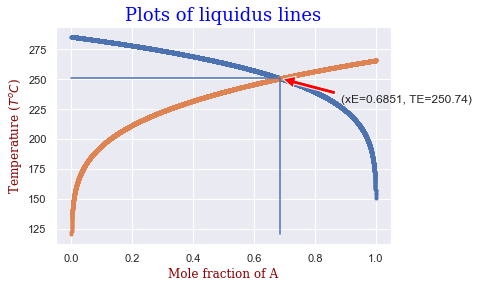

64.23314221092895
15.79945558826746
16131.107474096309


In [24]:
mix = EutecticMixture(A,B)
TE, xE = mix.eutectic_properties()
mix.plot_temp_AB()
print(mix.entropy())
print(mix.ds1)
print(mix.enthalpy())

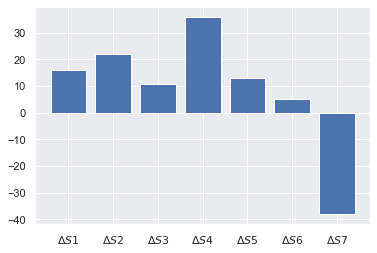

In [25]:
mix.plot_entropy()

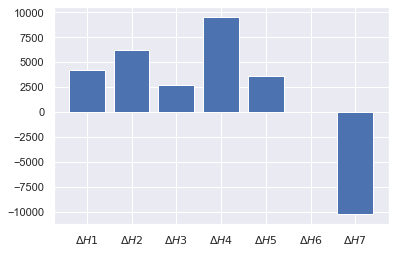

In [26]:
mix.plot_enthalpy()

mix.dh1

In [19]:
mix.ds1

15.79945558826746

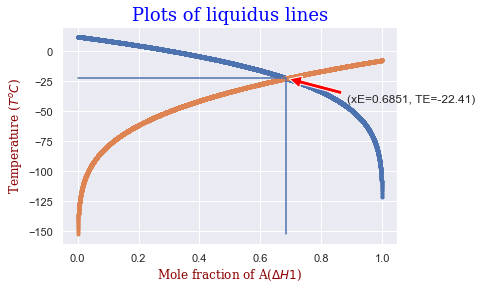

In [164]:
sns.set_theme()
plt.scatter(xA,temp_AB,marker =".")
plt.scatter(xA,temp_BA,marker =".")
# To plot lines
font1 = {'family':'serif','color':'blue','size':18}
font2 = {'family':'serif','color':'darkred','size':12}

min_value = min(temp_AB+temp_BA)
plt.plot([0,xE,xE],[TE,TE,min_value])
plt.title("Plots of liquidus lines",fontdict = font1)
#plt.text(-0.1,B.fusion_T-273.15,"$TB$")
plt.annotate(f'(xE={xE}, TE={round(TE,2)})', xy=(xE, TE),xytext=(xE+0.2,TE-20),arrowprops=dict(facecolor='red', shrink=0.05))
plt.xlabel("Mole fraction of A",fontdict = font2)
plt.ylabel("Temperature ($T^oC$)",fontdict = font2)
plt.show()


In [188]:
mix.TE

-22.406931232399046

In [189]:
mix.B.fusion_T

285.45

In [27]:
df.columns

Index(['pcm', 'molar_mass', 'T_fus', 'Del_H', 'cpsa', 'cpsb', 'cpsc', 'cpla',
       'cplb', 'cplc', 'cpld'],
      dtype='object')

In [28]:
#Calculation of xE, TE and DeltaH for the mixture for the given dataset

A = PcmProperties(df[df['pcm']==df['pcm'][0]].values.tolist()[0])
B = PcmProperties(df[df['pcm']==df['pcm'][1]].values.tolist()[0])
mix = EutecticMixture(A,B)
TE, xE = mix.eutectic_properties()
HE = mix.enthalpy()


,pcm_A,pcm_B,xE,TE,dH


In [48]:
df_out['pcm_A'].append('A1')
df_out['pcm_B'].append('A21')
df_out['xE'].append(0.651)
df_out['TE'].append(201)
df_out['dH'].append(161181)
df_out.head()

TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

In [51]:
data =[['pcm_A', 'pcm_B', 'xE', 'TE', 'dH'],['pcm_A', 'pcm_B', 'xE', 'TE', 'dH'],['pcm_A', 'pcm_B', 'xE', 'TE', 'dH']]
df = pd.DataFrame(data,columns=['pcm_A', 'pcm_B', 'xE', 'TE', 'dH'])
print(df)

   pcm_A  pcm_B  xE  TE  dH
0  pcm_A  pcm_B  xE  TE  dH
1  pcm_A  pcm_B  xE  TE  dH
2  pcm_A  pcm_B  xE  TE  dH


In [53]:
df

,pcm_A,pcm_B,xE,TE,dH
0,pcm_A,pcm_B,xE,TE,dH
1,pcm_A,pcm_B,xE,TE,dH
2,pcm_A,pcm_B,xE,TE,dH


In [94]:
data = []
for i in range(len(df)-1):
    for j in range(i+1,len(df)): 
        A = PcmProperties(df[df['pcm']==df['pcm'][i]].values.tolist()[0])
        B = PcmProperties(df[df['pcm']==df['pcm'][j]].values.tolist()[0])
        mix = EutecticMixture(A,B)
        TE, xE = mix.eutectic_properties()
        HE = mix.enthalpy()
        data.append([A.name,B.name,xE,round(TE-273.15,1),HE])
df_enthalpy = pd.DataFrame(data,columns=['pcm_A', 'pcm_B', 'xE', 'TE', 'dH'])
len(df_enthalpy)

        

105

In [97]:
df_enthalpy.to_csv('../data/eutectic_enthalpy.csv',index=False)

In [68]:
df_enthalpy

,pcm_A,pcm_B,xE,TE,dH
0,Heptanoic (enanthic) acid,Nonanoic (pelargonic) acid,0.6851,-22.406931,16131.107474
1,Heptanoic (enanthic) acid,Oleic (elainic) acid,0.8360,-14.711883,16849.661969
2,Heptanoic (enanthic) acid,Octanoic (caprylic) acid,0.7242,-20.306637,15567.607792
3,Heptanoic (enanthic) acid,Undecanoic (undecylic) acid,0.8252,-15.230577,16090.588665
4,Heptanoic (enanthic) acid,Decanoic (capric) acid,0.8321,-14.895488,15547.538389
...,...,...,...,...,...
100,Heptadecanoic (heptadecylic) acid,Octadecanoic (stearic) acid,0.6048,54.011531,54389.935747
101,Heptadecanoic (heptadecylic) acid,Eicosanoic (arachidic) acid,0.7310,57.272663,56248.100753
102,Nonadecanoic (nonadecylic) acid,Octadecanoic (stearic) acid,0.5126,57.151531,58391.070253
103,Nonadecanoic (nonadecylic) acid,Eicosanoic (arachidic) acid,0.6460,60.829175,61600.419554


In [69]:
selected_melting_T=-12

In [92]:
selected_melting_T=-12

def sort_nearby(x):
    return min(abs(x-selected_melting_T),abs(selected_melting_T-x))
df_enthalpy['d'] =df_enthalpy['TE'].apply(sort_nearby()) 
d =df_enthalpy.sort_values(by='d')
d.head(12)

,pcm_A,pcm_B,xE,TE,dH,d
5,Heptanoic (enanthic) acid,Tridecanoic (tridecylic) acid,0.9230,-10.703815,15301.399576,1.296185
6,Heptanoic (enanthic) acid,Dodecanoic (lauric) acid,0.9348,-10.185353,13571.476241,1.814647
1,Heptanoic (enanthic) acid,Oleic (elainic) acid,0.8360,-14.711883,16849.661969,2.711883
4,Heptanoic (enanthic) acid,Decanoic (capric) acid,0.8321,-14.895488,15547.538389,2.895488
7,Heptanoic (enanthic) acid,Pentadecanoic (pentadecylic) acid,0.9669,-8.779223,14646.964706,3.220777
3,Heptanoic (enanthic) acid,Undecanoic (undecylic) acid,0.8252,-15.230577,16090.588665,3.230577
8,Heptanoic (enanthic) acid,Tetradecanoic (myristic) acid,0.9751,-8.411861,13905.517926,3.588139
10,Heptanoic (enanthic) acid,Heptadecanoic (heptadecylic) acid,0.9925,-7.690014,14150.355089,4.309986
9,Heptanoic (enanthic) acid,Hexadecanoic (palmitic) acid,0.9924,-7.627060,14023.641848,4.372940
12,Heptanoic (enanthic) acid,Octadecanoic (stearic) acid,0.9971,-7.465304,13900.440015,4.534696


In [93]:
df_enthalpy['TE']=df_enthalpy['TE'].apply(round(1))
df_enthalpy

TypeError: 'int' object is not callable